In [36]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import pandas as pd


%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

In this notebook, I would like to simulate a complex causal process (with only linear relationships between the variables), but in a complex DAG that isn't just a triangle. Then, I would like to use this simulated data to convince myself that with the right conditioning on variables, we can recover the correct parameters back.

## Graphical Structure

First off, let's assume that there is the following graphical structure.

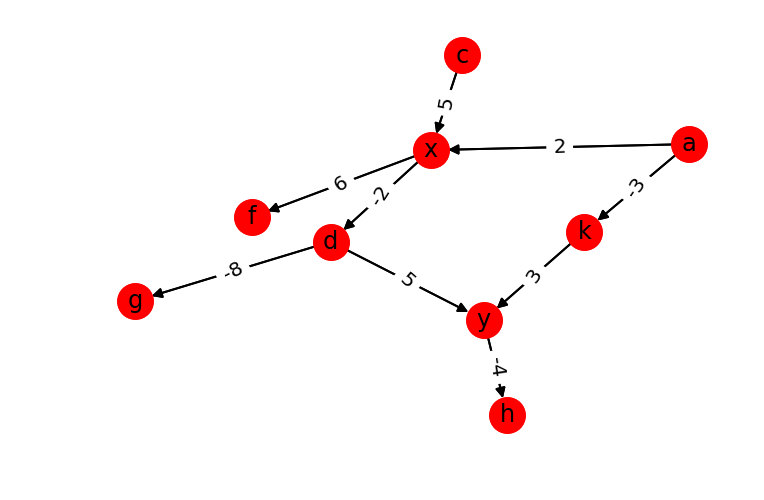

In [137]:
G = nx.DiGraph()
G.add_edge('c', 'x', coeff=5)
G.add_edge('a', 'x', coeff=2)
G.add_edge('a', 'k', coeff=-3)
G.add_edge('x', 'f', coeff=6)
G.add_edge('x', 'd', coeff=-2)
G.add_edge('d', 'g', coeff=-8)
G.add_edge('k', 'y', coeff=3)
G.add_edge('d', 'y', coeff=5)
G.add_edge('y', 'h', coeff=-4)


def draw_graph(G):
    edge_labels = {(u, v):d['coeff'] for u, v, d in G.edges(data=True)}
    pos = nx.kamada_kawai_layout(G)

    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_nodes(G, pos, with_labels=True)
    nx.draw_kamada_kawai(G, with_labels=True)
    
draw_graph(G)

Written as a set of equations, it might look like the following:

In [32]:
def noise(size):
    return npr.normal(loc=0, scale=1, size=size)

In [127]:
n = 1000  # number of samples taken

c = noise(n)
a = noise(n)
x = 5 * c + 2 * a + noise(n)
k = -3 * a + noise(n)
f = 6 * x + noise(n)
d = -2 * x + noise(n)
g = -8 * d + noise(n)
y = 3 * k + 5 * d + noise(n)
h = -4 * y + noise(n)

data = dict(c=c, a=a, x=x, k=k, f=f, d=d, g=g, y=y, h=h)
df = pd.DataFrame(data)
df.sample(5)

,a,c,d,f,g,h,k,x,y
882,0.027106,0.249160,-0.248890,5.769725,3.069505,-12.956515,2.231553,1.053636,3.378209
312,-1.338627,0.408478,2.851235,-3.089560,-22.446835,-134.934378,6.433772,-0.714430,33.457186
579,0.964660,-1.532000,11.619843,-33.613351,-93.231875,-196.508453,-3.140747,-5.662133,49.216816
941,-0.016419,0.324235,-2.894453,14.783572,23.351484,46.509948,0.683845,2.193436,-11.697399
364,-0.628576,2.014995,-13.954999,46.523522,112.098815,260.937619,1.168194,7.506108,-64.994570


Note how the coefficients on the edges are basically the linear multipliers.

Before we go on, let's get a feel for how the data are distributed.

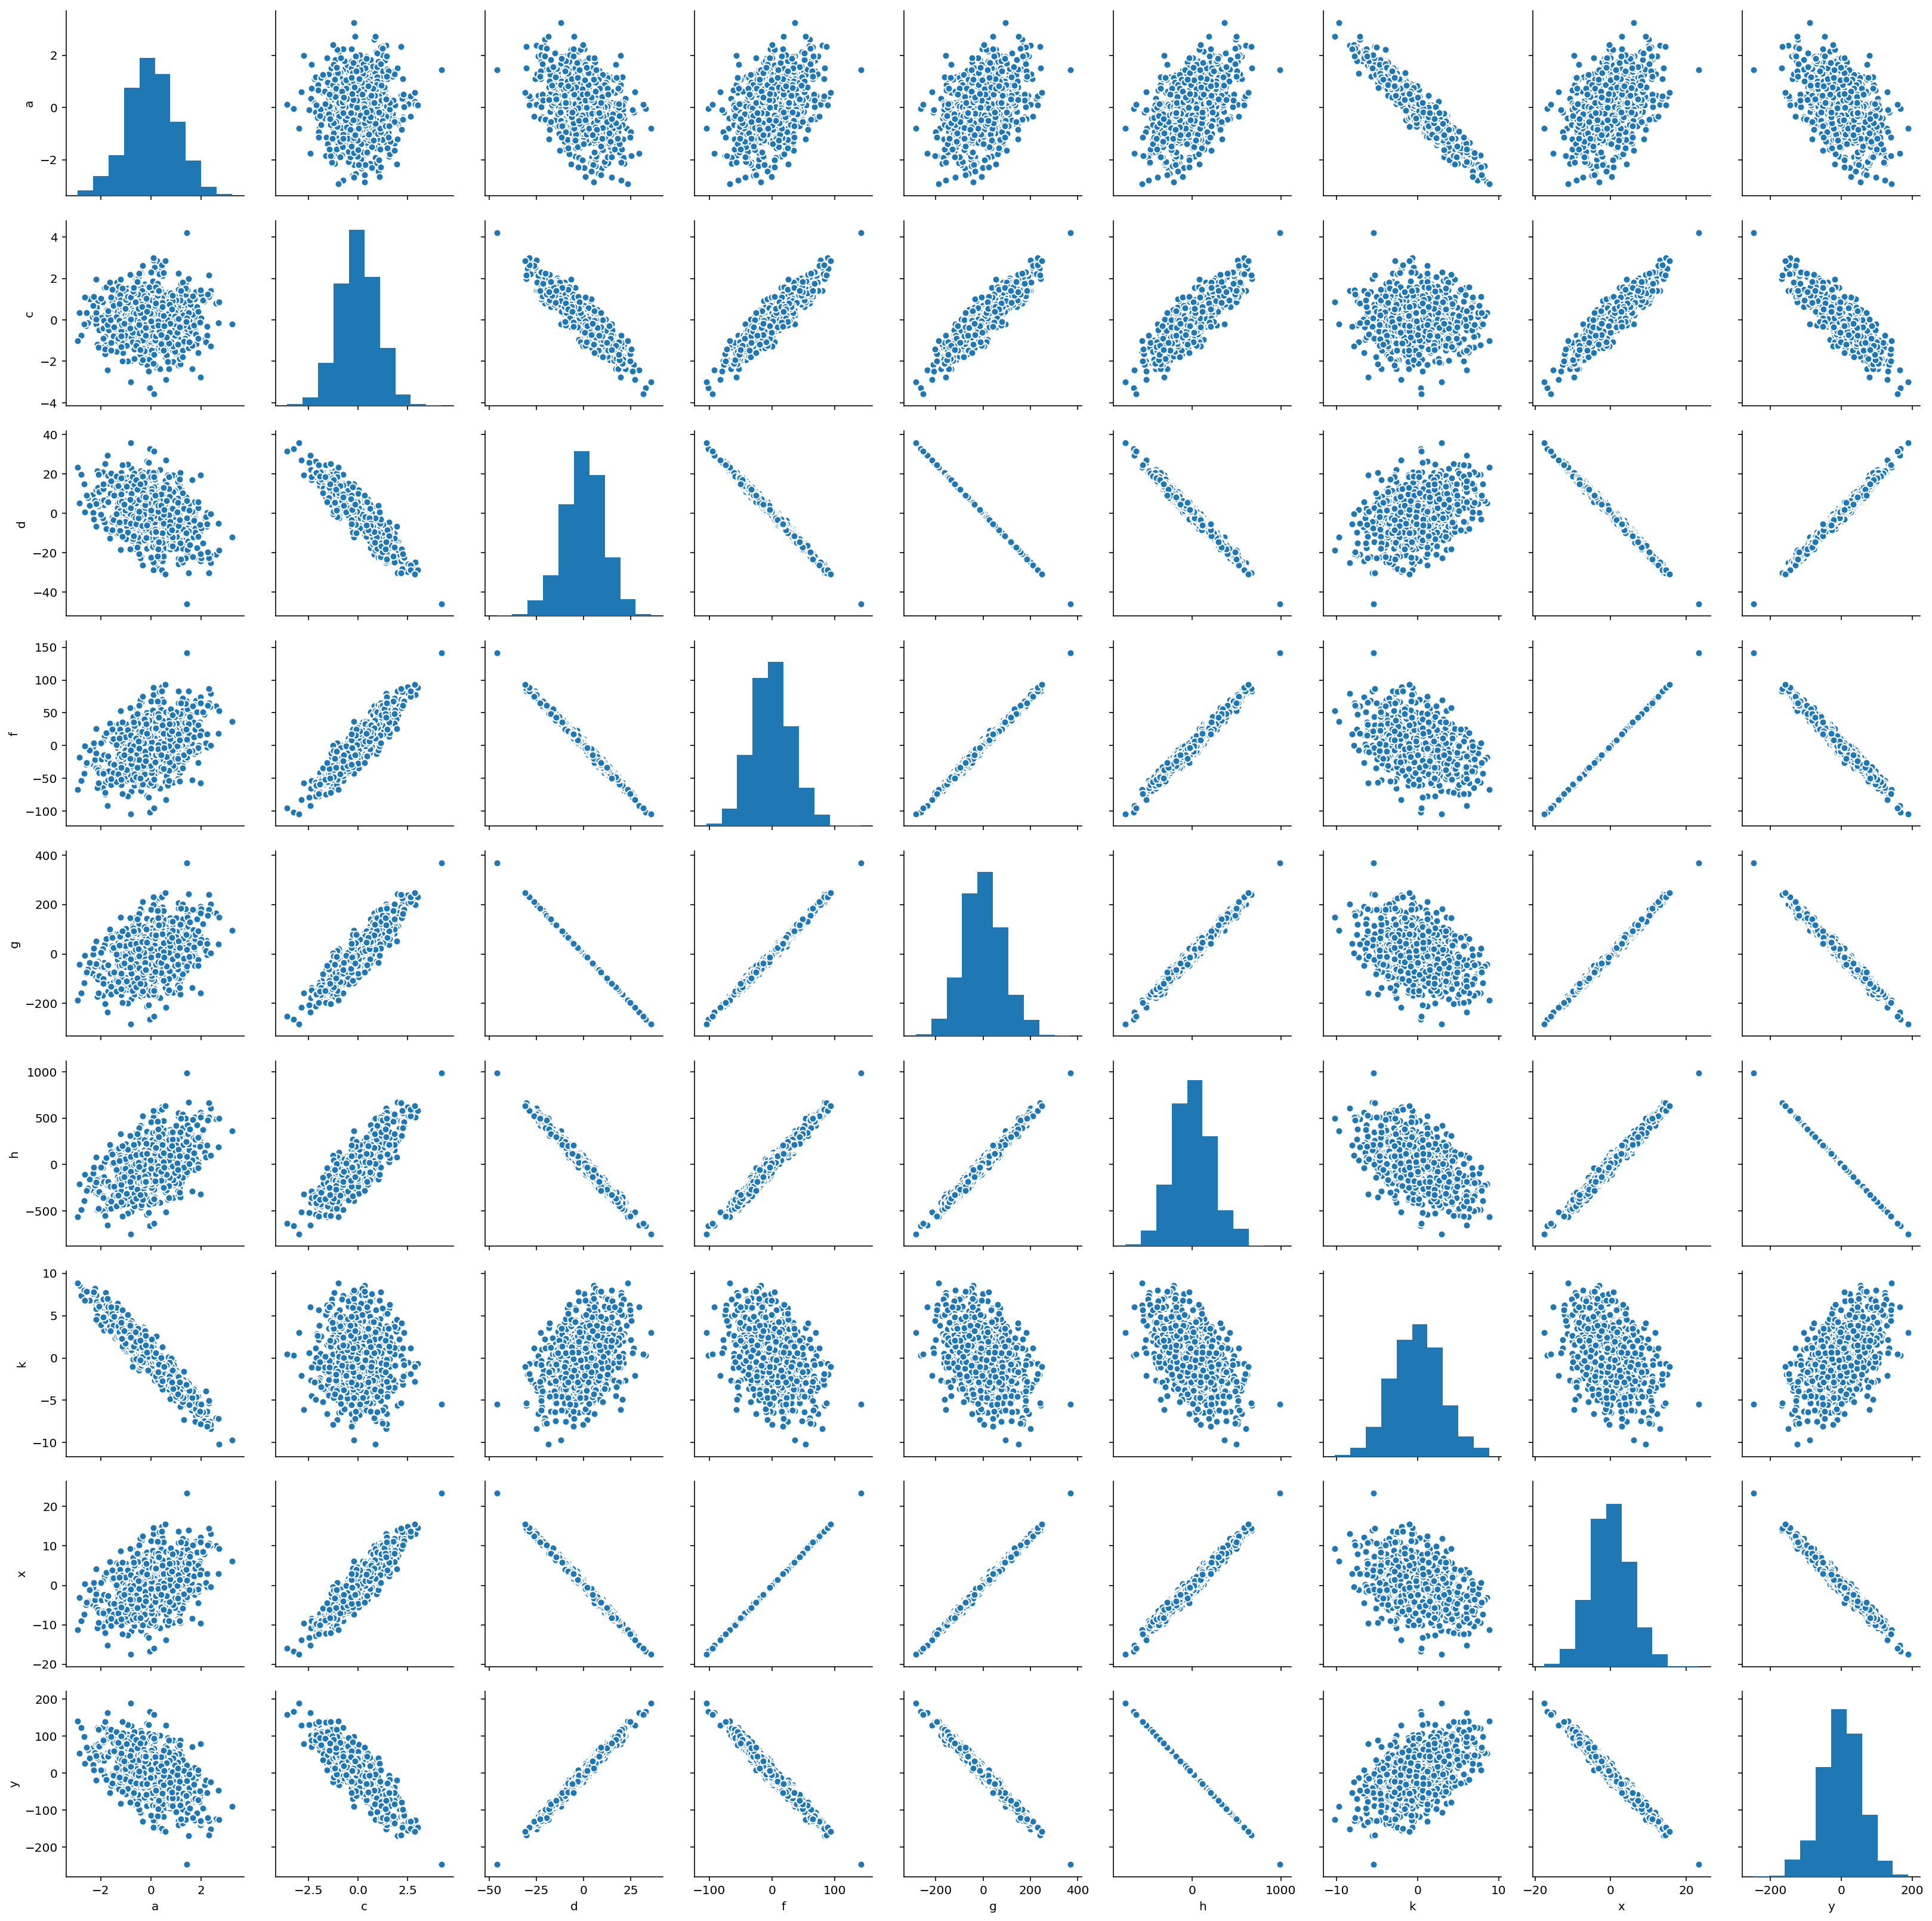

In [128]:
import seaborn as sns
sns.pairplot(df)

Looking at the pair plot above, we should compute the pairwise correlation between each pair of variables.

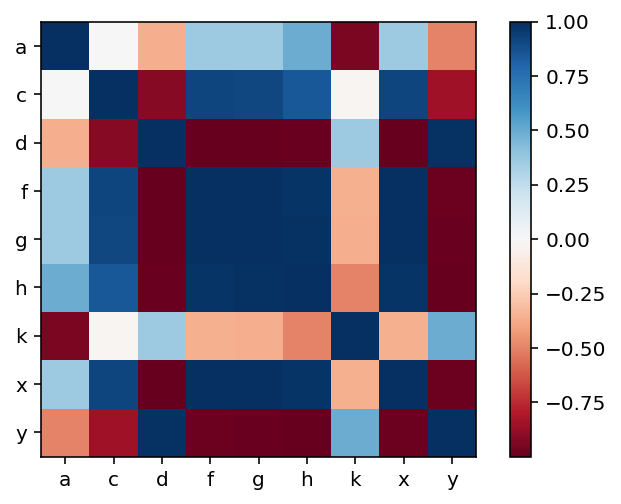

In [129]:
plt.imshow(df.corr(method='pearson').values, cmap='RdBu')
plt.xticks(range(len(df.columns)), df.columns)
plt.yticks(range(len(df.columns)), df.columns)
plt.colorbar()

Compare the graphical structure below against the correlation plots above. Some things are quite neat.

- `c` and `k` are uncorrelated, because there is no causal path from `c` to `k`. Same goes for `c` and `a`.
- On the other hand, `c` is causally related to all of the other variables. The only one it contains a negative correlation with is `d`, and this comes directly from Sewall Wright's path rules: positive coeff * negative coeff gives a negative coeff.

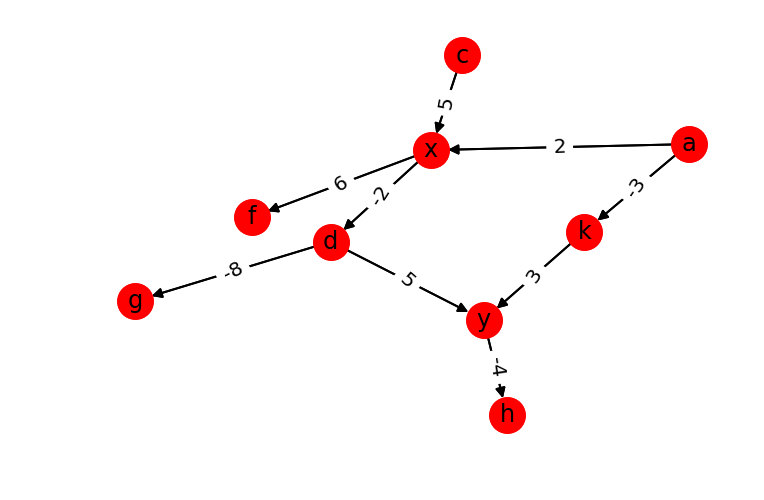

In [130]:
draw_graph(G)

From the graph, we know that the direct effect of `x` on `y` is going to be 2 x -5 = -10 (Sewall Wright's path analysis). However, if we only regress `y` on `x`, the coefficients are going to be wrong, because we have a confounder between `x` and `y`, primarily originating from `a`. 

Now, let's try naïvely regressing Y on X, given the causal structure above.

In [131]:
from statsmodels.regression.linear_model import OLS

model = OLS.from_formula('y ~ x', data=df)
results = model.fit()
results.params

Intercept    -0.341836
x           -10.637044
dtype: float64

We almost recover the correct coefficients, but because we didn't condition on the confounding path from `x` to `y`, that is, the path `x <- a -> k -> y`. Thus, we're still off. 

What if we conditioned on `a`? To condition on `a` means adding it as a term in the linear regression.

In [126]:
model = OLS.from_formula('y ~ x + a', data=df)
results = model.fit()
results.params

Intercept   -0.044878
x           -9.973738
a           -9.079687
dtype: float64

Much better! What if we conditioned on `k` only?

In [132]:
model = OLS.from_formula('y ~ x + k', data=df)
results = model.fit()
results.params

Intercept   -0.173608
x           -9.992567
k            3.122776
dtype: float64

Wonderful! We get coefficients that are much closer to -10, which is exactly what we had expected. Notice how we also recovered the effect of `a` and `k` respectively on `y`.

One thing that is quite nice about this scheme is that if we know the causality structure ahead of time, then we need not condition on every last variable. We needn't even condition on every single variable on the confounding path; conditioning on a single variable in each confounding path is sufficient. 

This property comes in handy in scenarios where we don't have perfect information: if we weren't able to measure `a`, or just forgot to measure it, `k` is a sufficiently good variable to condition on.

What would happen if we conditioned on a variable that wasn't involved in the causal path from `x` to `y`? Let's try conditioning on `g`.

In [133]:
model = OLS.from_formula('y ~ x + g', data=df)
results = model.fit()
results.params

Intercept   -0.122655
x            0.249419
g           -0.679664
dtype: float64

We are way off! This is because `g` is not a confounder of `x` and `y`, therefore, conditioning on it is the wrong thing to do.

One thing about this set of simulations is that *oftentimes we don't know the causal structure*. Assuming the data we have on-hand were the only things that we actually had, what causal structures could we rule-out?